Updates here: 

https://github.com/olehsamoilenko/habitats

In [21]:
import numpy as np
import pandas as pd
import ee

In [ ]:
ee.Authenticate()
ee.Initialize(project='osamoile-embeddings')

In [88]:
# 2017 year only
ic = ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL').filterDate(f'2017-01-01', f'2018-01-01').mosaic()

In [ ]:
# Olenka dataset
df = pd.read_csv("./data/eunis_habitats_combined_latlon.csv")
df

/var/folders/9b/r7dw9z61167f0rt5sthsgx_r0000gn/T/ipykernel_63636/348898670.py:2: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/eunis_habitats_combined_latlon.csv")


,UNCERTAINT,YEAR,PLOTOBSID,PRECISION,Level,Name_,Descriptio,habitat_code,lon,lat
0,10.0,2008.0,NaN,NaN,NaN,NaN,NaN,S11,20.846240,69.051250
1,10.0,2008.0,NaN,NaN,NaN,NaN,NaN,S11,20.819950,69.051850
2,-1.0,1967.0,NaN,NaN,NaN,NaN,NaN,S11,28.439941,70.491812
3,-1.0,1967.0,NaN,NaN,NaN,NaN,NaN,S11,26.732466,70.436174
4,-1.0,1967.0,NaN,NaN,NaN,NaN,NaN,S11,29.423309,70.096242
...,...,...,...,...,...,...,...,...,...,...
795041,NaN,1991.0,1398560.0,10000.0,NaN,NaN,NaN,U62,-13.614497,28.965913
795042,NaN,1991.0,1398582.0,10000.0,NaN,NaN,NaN,U62,-13.614497,28.965913
795043,NaN,1993.0,1545950.0,2000.0,NaN,NaN,NaN,U62,15.000542,37.718682
795044,NaN,1995.0,1545964.0,2000.0,NaN,NaN,NaN,U62,15.108915,37.663310


In [3]:
df.habitat_code.unique()

array(['S11', 'S12', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S31',
       'S32', 'S33', 'S34', 'S35', 'S36', 'S37', 'S38', 'S41', 'S42',
       'S43', 'S51', 'S52', 'S53', 'S54', 'S61', 'S62', 'S63', 'S64',
       'S65', 'S66', 'S67', 'S68', 'S71', 'S72', 'S73', 'S74', 'S75',
       'S76', 'S81', 'S82', 'S91', 'S92', 'S93', 'S94', 'MA211', 'MA221',
       'MA222', 'MA223', 'MA224', 'MA225', 'MA232', 'MA241', 'MA251',
       'MA252', 'MA253', 'V11', 'V12', 'V13', 'V14', 'V15', 'V32', 'V33',
       'V34', 'V35', 'V37', 'V38', 'V39', 'N11', 'N12', 'N13', 'N14',
       'N15', 'N16', 'N17', 'N18', 'N19', 'N1A', 'N1B', 'N1C', 'N1D',
       'N1E', 'N1F', 'N1G', 'N1H', 'N1J', 'N1K', 'N21', 'N22', 'N31',
       'N32', 'N33', 'N34', 'N35', 'Q11', 'Q12', 'Q21', 'Q22', 'Q23',
       'Q24', 'Q25', 'Q31', 'Q41', 'Q42', 'Q43', 'Q44', 'Q45', 'Q46',
       'Q51', 'Q52', 'Q53', 'Q54', 'T11', 'T12', 'T13', 'T14', 'T15',
       'T16', 'T17', 'T18', 'T19', 'T1A', 'T1B', 'T1C', 'T1D', 'T1E',
       'T1F'

In [6]:
def get_code_lvl1(name):
    if name[0] == 'M':
        return name[:2]
    else:
        return name[0]
    
def get_code_lvl2(name):
    if name[0] == 'M':
        return name[:3]
    else:
        return name[:2]

df['code_lvl1'] = df["habitat_code"].apply(get_code_lvl1)
df['code_lvl2'] = df["habitat_code"].apply(get_code_lvl2)
df.code_lvl2.unique()

array(['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'MA2', 'V1',
       'V3', 'N1', 'N2', 'N3', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'T1', 'T2',
       'T3', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'U2', 'U3', 'U5', 'U6'],
      dtype=object)

In [90]:
df.habitat_code.groupby(df.habitat_code).count().sort_values().to_csv('./out/count_by_code_all.csv')

df_2017 = df[df.YEAR == 2017]
df_2017.habitat_code.groupby(df_2017.habitat_code).count().sort_values().to_csv('./out/count_by_code_2017.csv')

len(df_2017)


2667

In [91]:
# only classes having > 10 entries
df_filtered = df_2017.groupby('habitat_code').filter(lambda g: len(g) >= 10)
# 10 entries per class
df_load_prep = df_filtered.groupby('habitat_code', group_keys=False).sample(n=10, random_state=0)
# only necessary info
df_load_prep_coords = df_load_prep[['lat', 'lon', 'habitat_code']].reset_index()
df_load_prep_coords

,index,lat,lon,habitat_code
0,60122,46.941635,37.365330,MA241
1,60136,45.782297,34.960465,MA241
2,59989,46.585929,30.760261,MA241
3,59988,46.585929,30.760261,MA241
4,59984,46.562563,30.747286,MA241
...,...,...,...,...
505,139616,42.618686,23.581804,V39
506,142580,46.558867,30.761146,V39
507,139615,42.638150,23.679582,V39
508,139637,42.898148,23.007527,V39


In [ ]:
def make_feat(row):
    return ee.Feature(ee.Geometry.Point([float(row.lon), float(row.lat)]),
                      {k: row[k] for k in row.index})

fc_points = ee.FeatureCollection(list(df_load_prep_coords.apply(make_feat, axis=1)))

In [ ]:
sampled = ic.sampleRegions(
              collection=fc_points,
              scale=10,
              geometries=False)

ee.batch.Export.table.toDrive(
    collection=sampled,
    description='embeddings_2017',
    fileNamePrefix='embeddings_2017',
    fileFormat='CSV'  
).start()

In [ ]:
# downloaded file from drive
df = pd.read_csv('./out/embeddings_2017.csv')
df

,system:index,A00,A01,A02,A03,A04,A05,A06,A07,A08,...,A59,A60,A61,A62,A63,habitat_code,index,lat,lon,.geo
0,0_0,0.000246,-0.153787,-0.135886,-0.160000,0.186082,0.124567,-0.007443,-0.012057,0.055363,...,0.062991,0.124567,0.017778,-0.035433,0.098424,MA241,60122,46.941635,37.365330,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,1_0,-0.022207,-0.160000,-0.041584,-0.119093,0.062991,0.160000,-0.147697,-0.012057,0.008858,...,0.124567,0.124567,-0.066990,-0.055363,-0.038447,MA241,60136,45.782297,34.960465,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,2_0,-0.153787,-0.236463,-0.079723,-0.124567,0.066990,-0.024606,0.024606,0.093564,-0.006151,...,0.084214,0.015748,-0.199862,-0.103406,-0.044844,MA241,59989,46.585929,30.760261,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,3_0,-0.153787,-0.236463,-0.079723,-0.124567,0.066990,-0.024606,0.024606,0.093564,-0.006151,...,0.084214,0.015748,-0.199862,-0.103406,-0.044844,MA241,59988,46.585929,30.760261,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,4_0,-0.027128,-0.186082,-0.024606,-0.244152,0.119093,0.251965,-0.124567,-0.000984,-0.066990,...,0.048228,0.017778,-0.113741,-0.035433,0.010396,MA241,59984,46.562563,30.747286,"{""type"":""MultiPoint"",""coordinates"":[]}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,505_0,-0.019931,-0.244152,-0.041584,-0.130165,0.206936,-0.048228,0.221453,0.012057,-0.032541,...,0.041584,0.130165,-0.186082,0.041584,-0.098424,V39,139616,42.618686,23.581804,"{""type"":""MultiPoint"",""coordinates"":[]}"
506,506_0,-0.108512,-0.236463,-0.124567,-0.098424,0.135886,-0.022207,-0.029773,0.035433,-0.055363,...,-0.141730,0.022207,-0.103406,-0.048228,0.038447,V39,142580,46.558867,30.761146,"{""type"":""MultiPoint"",""coordinates"":[]}"
507,507_0,-0.071111,-0.206936,-0.113741,-0.093564,0.186082,-0.015748,0.228897,-0.015748,0.041584,...,0.000000,0.108512,-0.172795,-0.003014,-0.044844,V39,139615,42.638150,23.679582,"{""type"":""MultiPoint"",""coordinates"":[]}"
508,508_0,-0.027128,-0.160000,-0.002215,-0.141730,0.251965,0.041584,0.088827,0.029773,0.059116,...,0.135886,0.071111,-0.172795,0.035433,0.006151,V39,139637,42.898148,23.007527,"{""type"":""MultiPoint"",""coordinates"":[]}"


In [ ]:
bands = [c for c in df.columns if c.startswith("A")]
X = df[bands].to_numpy(dtype=float)
y = df['habitat_code'].to_numpy()
print(X.shape)
print(y.shape)

(510, 64)
(510,)


In [62]:
labels = np.unique(y)
centroids = {}
counts = {}

labels

array(['MA241', 'N17', 'Q11', 'Q22', 'Q24', 'Q25', 'Q41', 'Q42', 'Q44',
       'Q51', 'Q52', 'Q53', 'Q54', 'R1A', 'R1B', 'R21', 'R22', 'R23',
       'R35', 'R37', 'R43', 'R44', 'R55', 'S32', 'S35', 'S42', 'S64',
       'S66', 'T12', 'T15', 'T17', 'T19', 'T1E', 'T1F', 'T21', 'T31',
       'T35', 'T36', 'T3F', 'T3G', 'T3J', 'T3K', 'U27', 'U37', 'V11',
       'V15', 'V32', 'V34', 'V37', 'V38', 'V39'], dtype=object)

In [100]:
for lbl in labels:
    idx = (y == lbl)
    counts[lbl] = int(idx.sum())
    c = X[idx].mean(axis=0)
    # re-normalize centroid so cosine = dot(vec, centroid)
    c = c / (np.linalg.norm(c) + 1e-12)
    centroids[lbl] = c

list(centroids.items())[0]

('MA241',
 array([-0.0541903 , -0.20137015, -0.09898478, -0.16932966,  0.12724292,
         0.15253879, -0.0517512 ,  0.03946383,  0.0017109 ,  0.06251149,
         0.10918656, -0.13784767, -0.2130778 , -0.07027418, -0.16807122,
         0.049503  , -0.19796956,  0.04896569, -0.03745599,  0.13087681,
        -0.10895325, -0.00052317, -0.12360195,  0.11489191,  0.07159623,
         0.1409584 ,  0.17207982, -0.1641404 ,  0.24174599,  0.00102513,
        -0.12145272,  0.01265501,  0.19311966, -0.09236741, -0.12881242,
         0.2439235 , -0.07892766,  0.02826521, -0.02769255,  0.21168505,
         0.10685351, -0.07858123,  0.07186489, -0.13002136,  0.1011835 ,
        -0.04596808,  0.13166157,  0.02237603,  0.23100691, -0.24530212,
        -0.12986583,  0.0491495 ,  0.2477907 , -0.12747622,  0.00127964,
        -0.07966999,  0.07558362, -0.06207316, -0.03554007,  0.10057549,
         0.08895268, -0.09190081, -0.06412342,  0.02230533]))

In [101]:
# Per-sample cosine similarity to its centroid; distances/variance
def cos_to_centroid(vecs, c):
    return (vecs @ c)  # since both are unit-length, this is cosine similarity

rows = []
for lbl in labels:
    idx = (y == lbl)
    sims = cos_to_centroid(X[idx], centroids[lbl])
    rows.append({
        "label": lbl,
        "mean_cos": float(sims.mean()),
        "median_cos": float(np.median(sims)),
        "std_cos": float(sims.std()),
    })

rows[:5]

[{'label': 'MA241',
  'mean_cos': 0.8701021811817041,
  'median_cos': 0.8750991607015359,
  'std_cos': 0.03672474928771214},
 {'label': 'N17',
  'mean_cos': 0.9381205168676235,
  'median_cos': 0.9443972671404454,
  'std_cos': 0.03407375037005898},
 {'label': 'Q11',
  'mean_cos': 0.8116076881101921,
  'median_cos': 0.812193433092672,
  'std_cos': 0.09455414639580863},
 {'label': 'Q22',
  'mean_cos': 0.750004625998358,
  'median_cos': 0.8045672652319579,
  'std_cos': 0.12443090773426212},
 {'label': 'Q24',
  'mean_cos': 0.7926674299198171,
  'median_cos': 0.8282970010347503,
  'std_cos': 0.10248704851343059}]

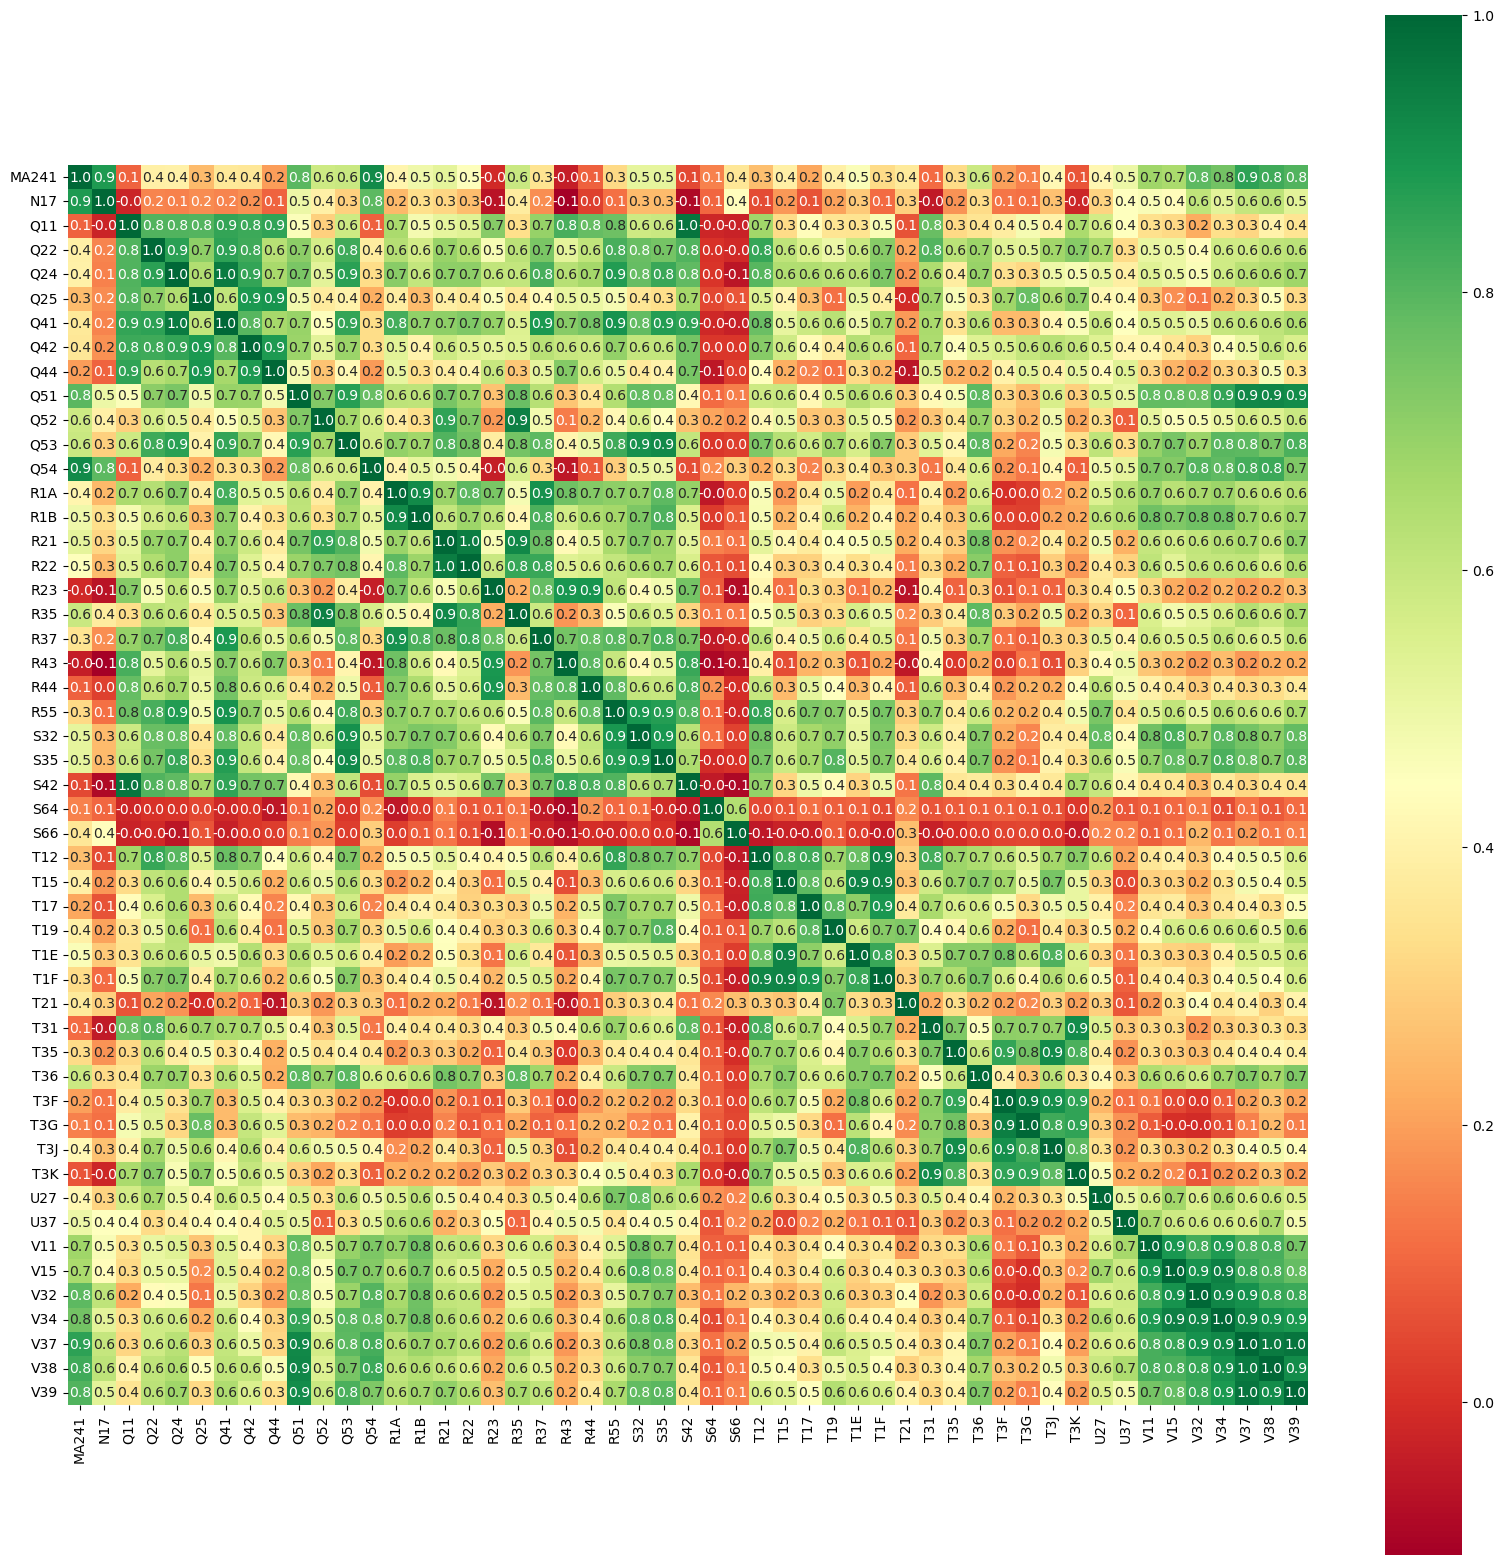

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def build_similarity_matrix(embs, labels):
    S = embs @ embs.T
    sim_df = pd.DataFrame(S, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(20, 20))
    
    sns.heatmap(sim_df, annot=True, fmt=".1f", square=True, ax=ax,
                xticklabels=True, yticklabels=True, cmap="RdYlGn")
    plt.savefig('./out/habitats_cluster_centers_cosine_distance.png')
    plt.show()

build_similarity_matrix(np.array(list(centroids.values())), centroids.keys())